In [40]:
%reload_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(".."))

from src.data_eng.pipeline import run_pipeline


Create Config

add additional interaction features

In [41]:
from src.config import Config

conf = Config(
    #features=[], all features
    add_int_features=True,
    target={'horizon': 5, 'threshold': 0.01},
   # ticker_list=['AAPL','META'], #all tickers
    validate_cutoff='2022-01-01',      # FINAL TEST START
    fold_len='365D',
    fold_mode='expanding',             # or 'sliding'
    sliding_train_years=None,          # set e.g. 5 if using sliding
 #   embargo_days=None                  # defaults to horizon=5
)

In [6]:
run_pipeline(conf)

begin fetching data from yfinance...
['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TSM', 'ORCL', 'WMT', 'JPM', 'INTC', 'UNH', 'HD']
saved: ../data/raw/AAPL.csv
saved: ../data/raw/MSFT.csv
saved: ../data/raw/NVDA.csv
saved: ../data/raw/GOOGL.csv
saved: ../data/raw/AMZN.csv
saved: ../data/raw/META.csv
saved: ../data/raw/TSLA.csv
saved: ../data/raw/AVGO.csv
saved: ../data/raw/TSM.csv
saved: ../data/raw/ORCL.csv
saved: ../data/raw/WMT.csv
saved: ../data/raw/JPM.csv
saved: ../data/raw/INTC.csv
saved: ../data/raw/UNH.csv
saved: ../data/raw/HD.csv
done fetching data
being data cleaning...
done cleaning data
begin feature engineering
make features for AAPL
make features for MSFT
make features for NVDA
make features for GOOGL
make features for AMZN
make features for META
make features for TSLA
make features for AVGO
make features for TSM
make features for ORCL
make features for WMT
make features for JPM
make features for INTC
make features for UNH
make features for HD
Done 

In [3]:
import numpy as np
import pandas as pd


## Hyperparameter tuning

### Linear SVC

In [42]:
from sklearn.svm import LinearSVC
# 1) build preprocessor with imputation to kill NaNs from lags/rolls
from src.modeling.eval import make_global_linear_pipeline

def lsvc_factory(C):
    return LinearSVC(
            penalty="l2",
            loss="hinge",           
            dual=True,             
            class_weight="balanced",
            C=C,
            max_iter=20000,         
            random_state=42
        )

In [ ]:

from src.modeling.helpers import num_cols_fn, make_linear_pipeline
from src.modeling.nested_cv import nested_param_sweep
from src.modeling.export import dump_csv_metrics
from sklearn.metrics import roc_auc_score
from src.data_eng.folds import load_multi_ticker_collection
from src.modeling.global_pairs import build_global_fold_pairs

In [45]:
# 1) get data
collection = load_multi_ticker_collection(conf)

# 2) build global fold pairs
pairs = build_global_fold_pairs(collection)


C_grid = np.logspace(-4, 0, 15)

inner_df, outer_df, final_param = nested_param_sweep(
    pairs=pairs,
    num_cols_fn=num_cols_fn,
    make_pipeline=make_linear_pipeline,
    model_factory=lsvc_factory,
    param_grid=C_grid,
    scorer=roc_auc_score,   # using AUC on margins
    inner_splits=3,
)

inner_df = inner_df.rename(columns={"param": "C", "metric": "auc"})
outer_df = outer_df.rename(columns={"param": "C", "inner_mean_metric": "inner_mean_auc"})

final_C = float(np.median(outer_df["C"]))



/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

In [31]:
print({"final_C": final_C})
print("\nOuter-fold summary:")
print(outer_df.sort_values("fold").to_string(index=False))

dump_csv_metrics(inner_df, 'cv_inner_results', conf)
dump_csv_metrics(outer_df, 'cv_outer_results', conf)


{'final_C': 0.00019306977288832496}

Outer-fold summary:
 fold        C  inner_mean_auc  val_auc  val_accuracy  n_val
    0 0.000720        0.499360 0.547211      0.531301   3706
    1 0.001389        0.490261 0.510410      0.480842   3706
    2 0.000193        0.483003 0.535479      0.502836   3703
    3 0.000373        0.490803 0.523470      0.466739   3698
    4 0.000100        0.505181 0.529427      0.466811   3706
    5 0.000100        0.509360 0.542489      0.475728   3708
    6 0.000100        0.509989 0.550506      0.467529   3711
    7 0.000100        0.514218 0.522296      0.455232   3708
    8 0.000373        0.516700 0.564595      0.435776   3589
writing csv:  /home/mike/Git-projects/StockPrediction/data/model_metrics/cv_inner_results.csv
writing csv:  /home/mike/Git-projects/StockPrediction/data/model_metrics/cv_outer_results.csv


### Inner CV mean AUC vs C

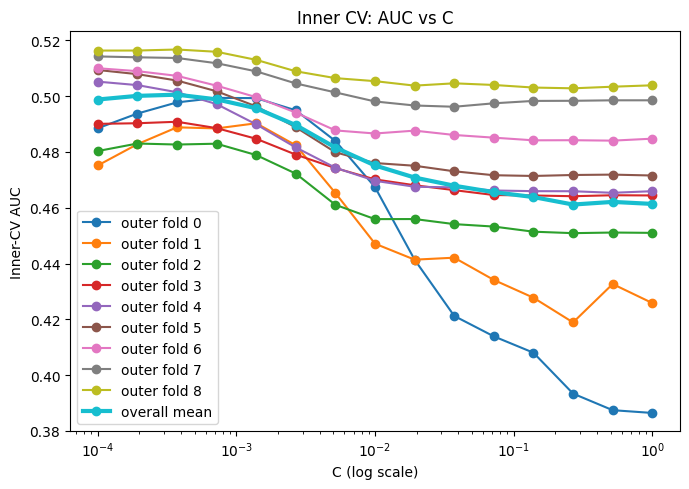

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,5))
for k in sorted(inner_df["outer_fold"].unique()):
    tmp = (inner_df[inner_df["outer_fold"] == k]
           .groupby("C", as_index=False)["auc"].mean()
           .sort_values("C"))
    plt.plot(tmp["C"], tmp["auc"], marker="o", label=f"outer fold {k}")

# Overall mean across outer folds (bold line)
overall = (inner_df.groupby("C", as_index=False)["auc"].mean().sort_values("C"))
plt.plot(overall["C"], overall["auc"], marker="o", linewidth=3, label="overall mean")

plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Inner-CV AUC")
plt.title("Inner CV: AUC vs C")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### C distribution across outer folds

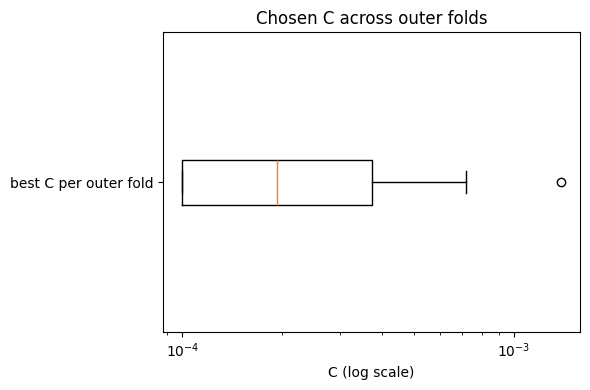

In [12]:
fig = plt.figure(figsize=(6,4))
plt.boxplot(outer_df["C"], vert=False, tick_labels=["best C per outer fold"])
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.title("Chosen C across outer folds")
plt.tight_layout()
plt.show()


### Outer Fold Validation performance

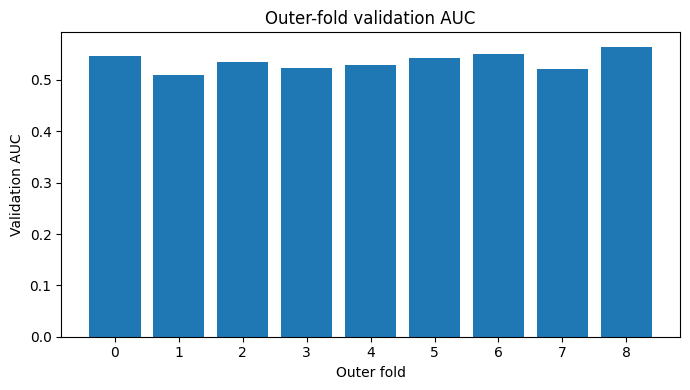

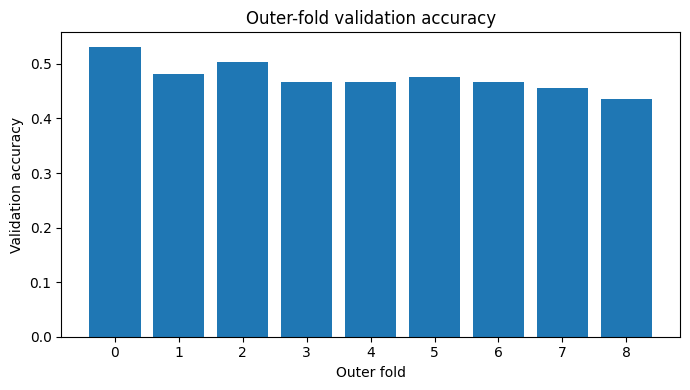

In [9]:
fig = plt.figure(figsize=(7,4))
plt.bar(outer_df["fold"].astype(str), outer_df["val_auc"])
plt.xlabel("Outer fold")
plt.ylabel("Validation AUC")
plt.title("Outer-fold validation AUC")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(7,4))
plt.bar(outer_df["fold"].astype(str), outer_df["val_accuracy"])
plt.xlabel("Outer fold")
plt.ylabel("Validation accuracy")
plt.title("Outer-fold validation accuracy")
plt.tight_layout()
plt.show()


### Final SVC Test based on best C

In [ ]:
from src.modeling.global_pairs import build_global_insample_and_test
from sklearn.metrics import accuracy_score
# 4) final test
X_ins, y_ins, X_test, y_test = build_global_insample_and_test(collection, dropna_features=True)
num_cols = [c for c in X_ins.columns if c not in ("__ticker__", "Date")]


final_pipe = make_global_linear_pipeline(num_cols, lsvc_factory(final_C))
final_pipe.fit(X_ins, y_ins)

final_auc = roc_auc_score(y_test, final_pipe.decision_function(X_test))
final_acc = accuracy_score(y_test, (final_pipe.decision_function(X_test) >= 0).astype(int))
print({"final_auc": final_auc, "final_acc": final_acc})

{'final_auc': 0.5378457217694667, 'final_acc': 0.4612177413557616}


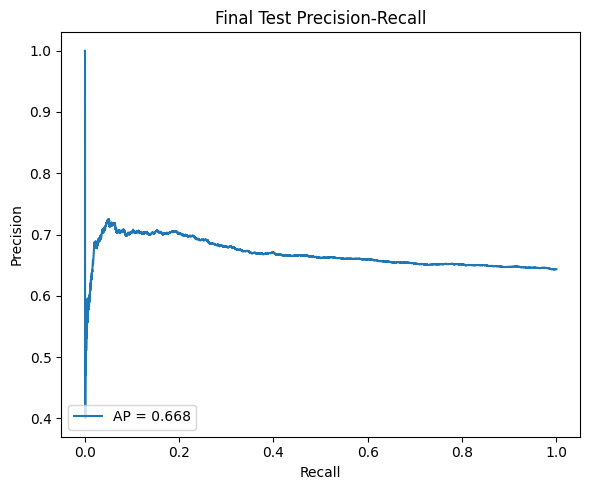

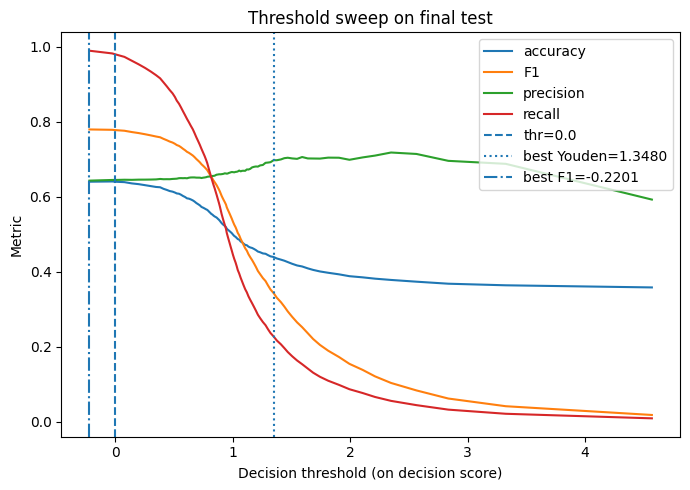

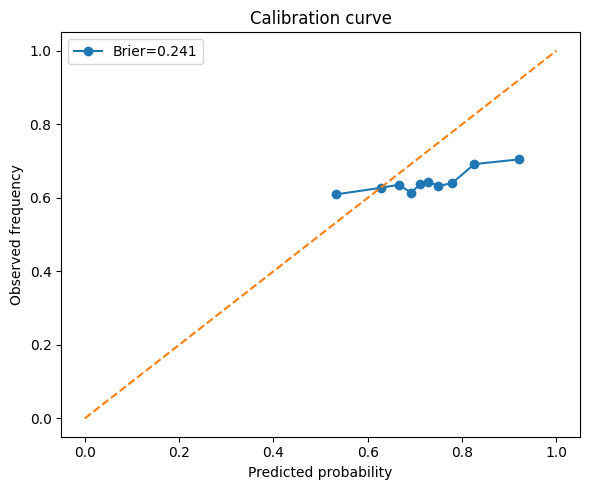

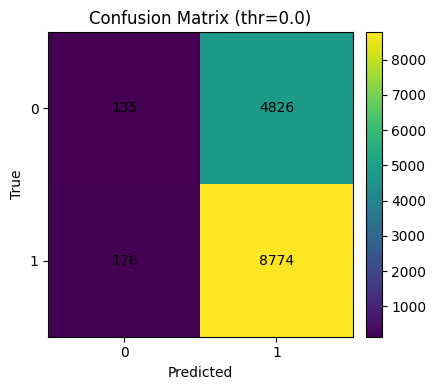

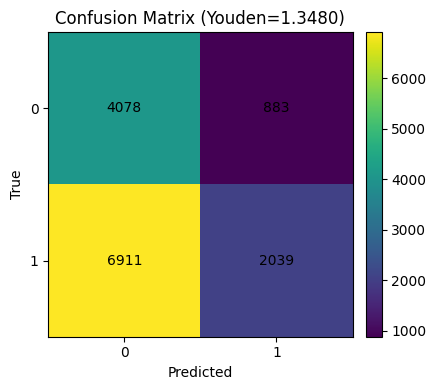

Report @ thr=0.0
              precision    recall  f1-score   support

           0      0.434     0.027     0.051      4961
           1      0.645     0.980     0.778      8950

    accuracy                          0.640     13911
   macro avg      0.540     0.504     0.415     13911
weighted avg      0.570     0.640     0.519     13911


Report @ best Youden
              precision    recall  f1-score   support

           0      0.371     0.822     0.511      4961
           1      0.698     0.228     0.343      8950

    accuracy                          0.440     13911
   macro avg      0.534     0.525     0.427     13911
weighted avg      0.581     0.440     0.403     13911



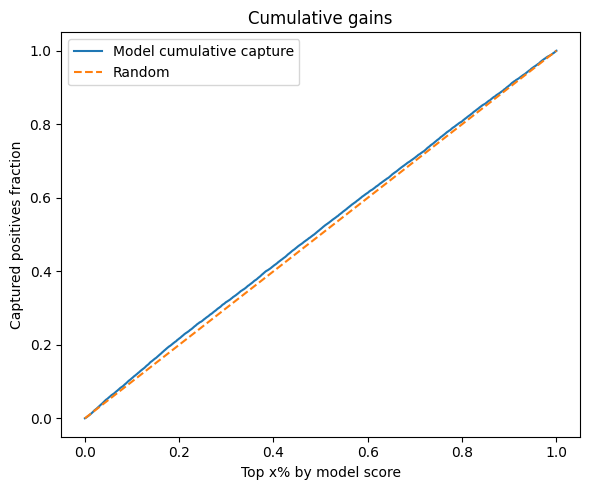

/home/mike/Git-projects/StockPrediction/src/visualization/eval_plots.py:242: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_ticker = df_eval.groupby("ticker").apply(


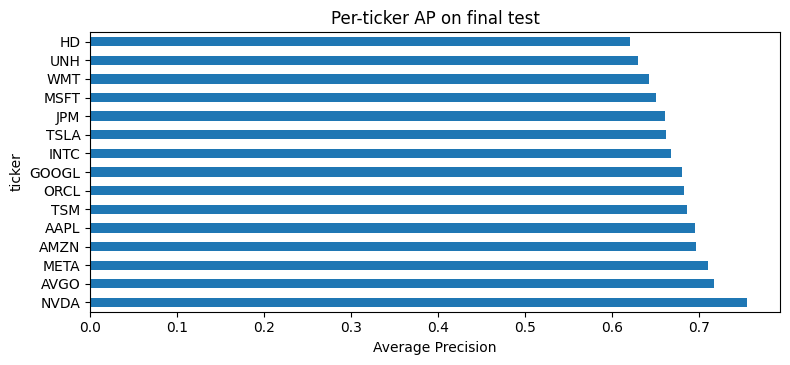

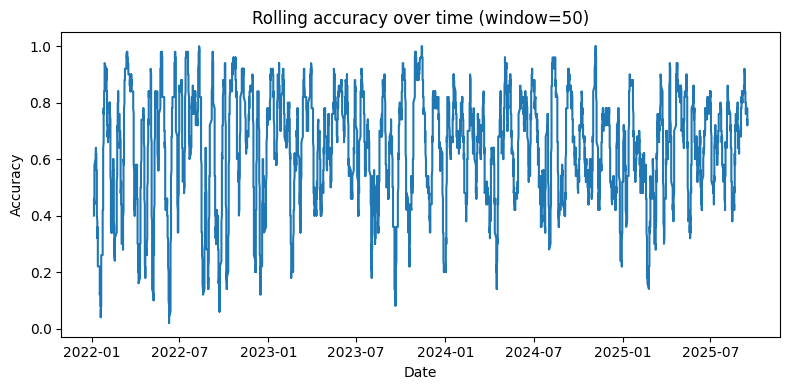

In [39]:
from src.visualization.eval_plots import run_full_eval_and_plots

df_eval, stats, sweep = run_full_eval_and_plots(
    final_pipe,
    X_test,
    y_test,
    out_dir=conf.data_dir / "model_metrics" / 'svc',
    proba_strategy="auto",   # "model" for real probs, "sigmoid" to force margin->prob, "none" to skip probs
)

### Stochastic Gradient Descent Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from src.data_eng.folds import load_multi_ticker_collection
from src.modeling.global_pairs import build_global_fold_pairs
from src.modeling.nested_cv import nested_param_sweep
from src.modeling.helpers import num_cols_fn, make_linear_pipeline

In [ ]:

coll_sgd = load_multi_ticker_collection(conf)
pairs_sgd = build_global_fold_pairs(coll_sgd)



# model factory for SGD with alpha
def sgd_factory(alpha: float):
    return SGDClassifier(
        loss="hinge",      
        penalty="l2",
        alpha=alpha,
        max_iter=2000,
        tol=1e-3,
        random_state=42,
        early_stopping=False,
        class_weight=None,
        average=True          
)

# grid to sweep (alpha acts like 1/C; smaller alpha = weaker regularization)
alpha_grid = np.logspace(-6, -2, 12)

inner_df, outer_df, final_alpha = nested_param_sweep(
    pairs=pairs_sgd,
    num_cols_fn=num_cols_fn,
    make_pipeline=make_linear_pipeline,
    model_factory=sgd_factory,
    param_grid=alpha_grid,
    scorer=roc_auc_score,
    inner_splits=3,
)

print("final_alpha:", final_alpha)
display(outer_df.sort_values("fold"))

final_alpha: 0.0001519911082952933


,fold,param,inner_mean_metric,val_auc,val_accuracy,n_val
0,0,0.000066,0.423771,0.548579,0.631678,3706
1,1,0.000001,0.466342,0.515089,0.650297,3706
2,2,0.004329,0.483616,0.543520,0.627869,3703
3,3,0.004329,0.494044,0.532622,0.646025,3698
4,4,0.000001,0.490096,0.543713,0.655963,3706
5,5,0.000152,0.497949,0.529072,0.654261,3708
6,6,0.010000,0.503153,0.543994,0.646995,3711
7,7,0.001874,0.510069,0.531780,0.648328,3708
8,8,0.000066,0.514165,0.552463,0.656729,3589


## Final SGD Test

In [ ]:
from src.modeling.global_pairs import build_global_insample_and_test
from sklearn.metrics import accuracy_score
# 4) final test
X_ins, y_ins, X_test, y_test = build_global_insample_and_test(collection, dropna_features=True)
num_cols = [c for c in X_ins.columns if c not in ("__ticker__", "Date")]


final_pipe = make_global_linear_pipeline(num_cols, sgd_factory(final_alpha))
final_pipe.fit(X_ins, y_ins)

final_auc = roc_auc_score(y_test, final_pipe.decision_function(X_test))
final_acc = accuracy_score(y_test, (final_pipe.decision_function(X_test) >= 0).astype(int))
print({"final_auc": final_auc, "final_acc": final_acc})

{'final_auc': 0.5311266763436369, 'final_acc': 0.6404284379268205}


*That High accuracy might indicate an error, usually future leakage. \
But AUC looks reasonably bad, again as expected, we aren't beating the market with a simple linear model

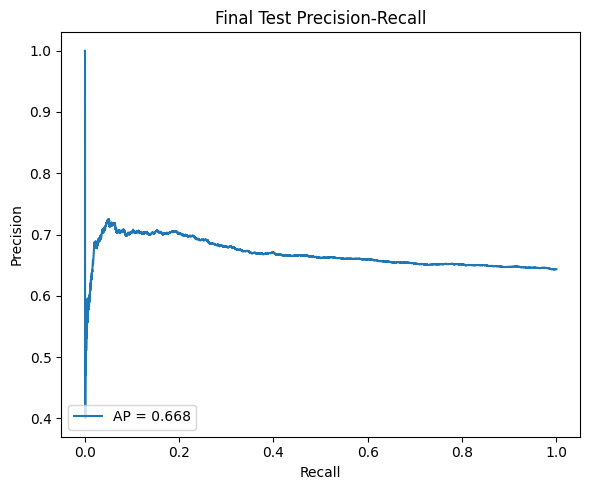

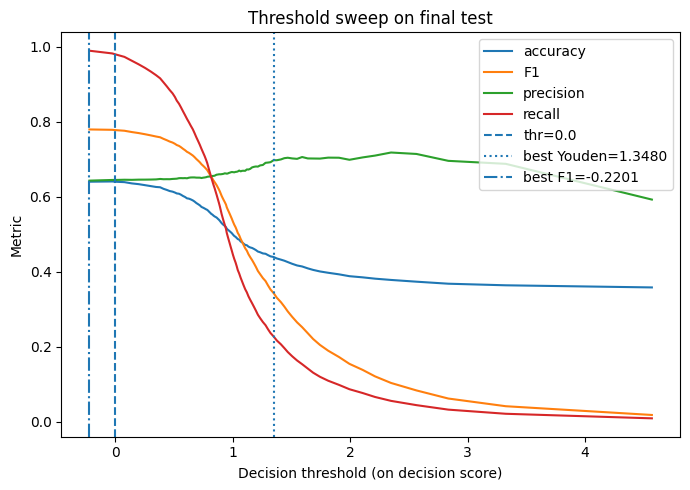

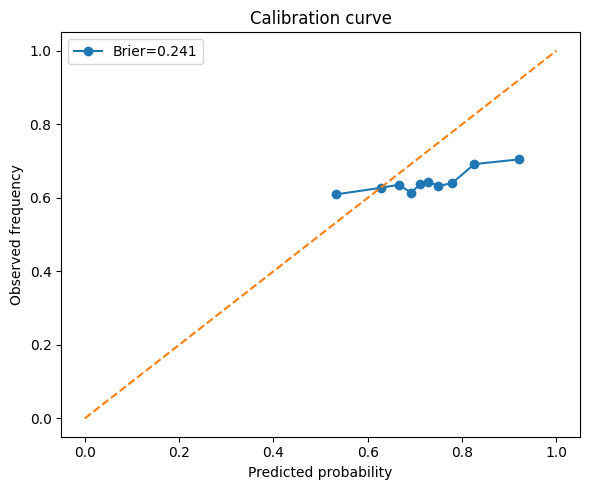

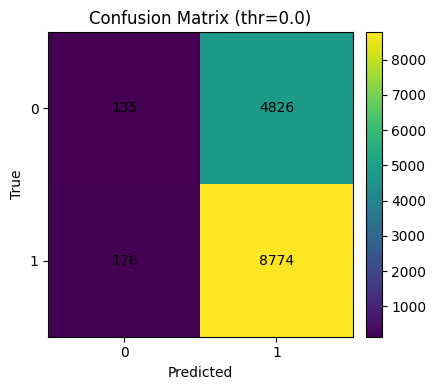

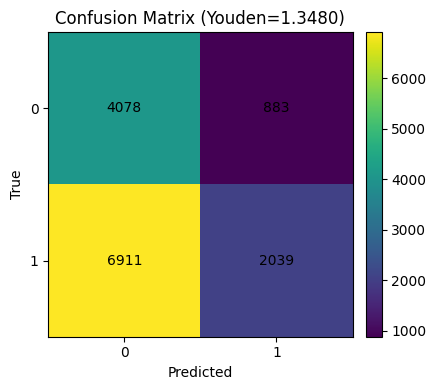

Report @ thr=0.0
              precision    recall  f1-score   support

           0      0.434     0.027     0.051      4961
           1      0.645     0.980     0.778      8950

    accuracy                          0.640     13911
   macro avg      0.540     0.504     0.415     13911
weighted avg      0.570     0.640     0.519     13911


Report @ best Youden
              precision    recall  f1-score   support

           0      0.371     0.822     0.511      4961
           1      0.698     0.228     0.343      8950

    accuracy                          0.440     13911
   macro avg      0.534     0.525     0.427     13911
weighted avg      0.581     0.440     0.403     13911



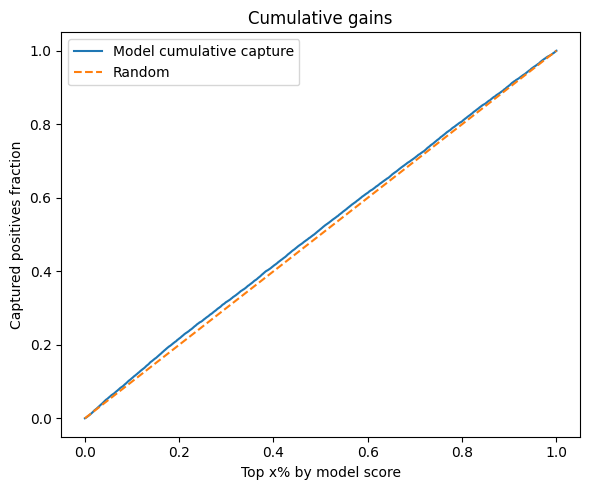

/home/mike/Git-projects/StockPrediction/src/visualization/eval_plots.py:242: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_ticker = df_eval.groupby("ticker").apply(


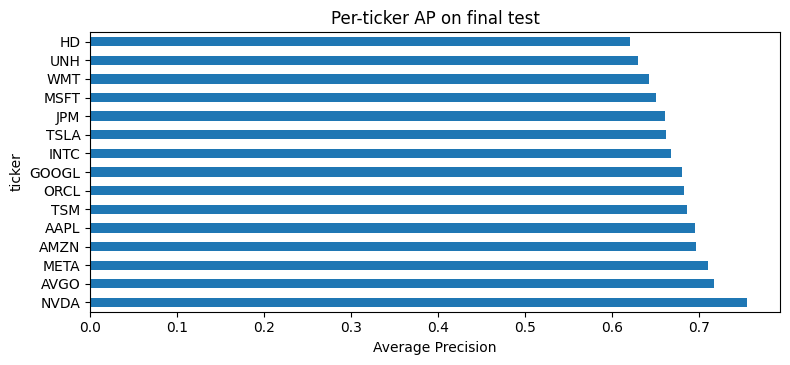

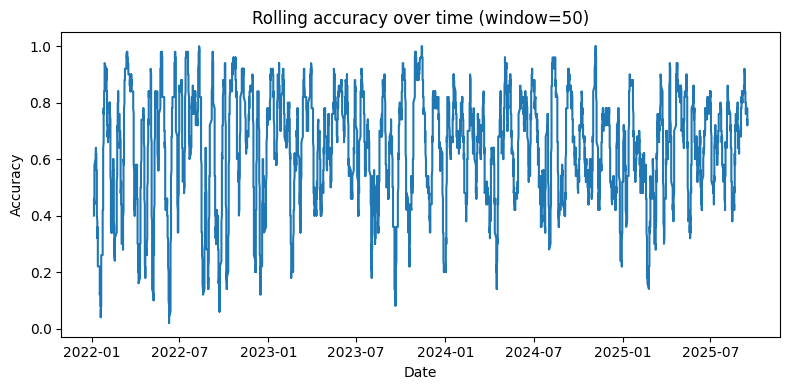

{'roc_auc': 0.5311266763436369, 'average_precision': 0.6680908378612336, 'best_youden_thr': 1.3479911523044765, 'best_f1_thr': -0.22010632084919432}


In [38]:
df_eval, stats, sweep = run_full_eval_and_plots(
    final_pipe,
    X_test,
    y_test,
    out_dir=conf.data_dir / "model_metrics" / 'sgd',
    proba_strategy="auto",
)

print(stats)